<a href="https://www.kaggle.com/code/ericmutisya/carts-and-linear-classification-models-ensemble?scriptVersionId=139810973" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Dataset Information

<mark>Attribute Information:</mark>

<mark>Id number:</mark> 1 to 214 (removed from CSV file)

<mark>RI:</mark> refractive index

<mark>Na:</mark> Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)

<mark>Mg:</mark> Magnesium

<mark>Al:</mark> Aluminum

<mark>Si:</mark> Silicon

<mark>K:</mark> Potassium

<mark>Ca:</mark> Calcium

<mark>Ba:</mark> Barium

<mark>Fe:</mark> Iron

<mark>Type of glass: (class attribute)</mark>

-- 1 building_windows_float_processed

-- 2 building_windows_non_float_processed

-- 3 vehicle_windows_float_processed

-- 4 vehicle_windows_non_float_processed (none in this database)

-- 5 containers

-- 6 tableware

-- 7 headlamps

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.preprocessing import StandardScaler # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV) # model selection modules
from collections import Counter
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
# load models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier)


%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/glass/glass.csv


In [2]:
df = pd.read_csv('/kaggle/input/glass/glass.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Exploratory Data Analysis

In [3]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


This data will require scaling, especially when dealing with loistic regression and KNN

In [4]:
df.isna().any()

RI      False
Na      False
Mg      False
Al      False
Si      False
K       False
Ca      False
Ba      False
Fe      False
Type    False
dtype: bool

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [6]:
df.columns

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], dtype='object')

<Figure size 800x800 with 0 Axes>

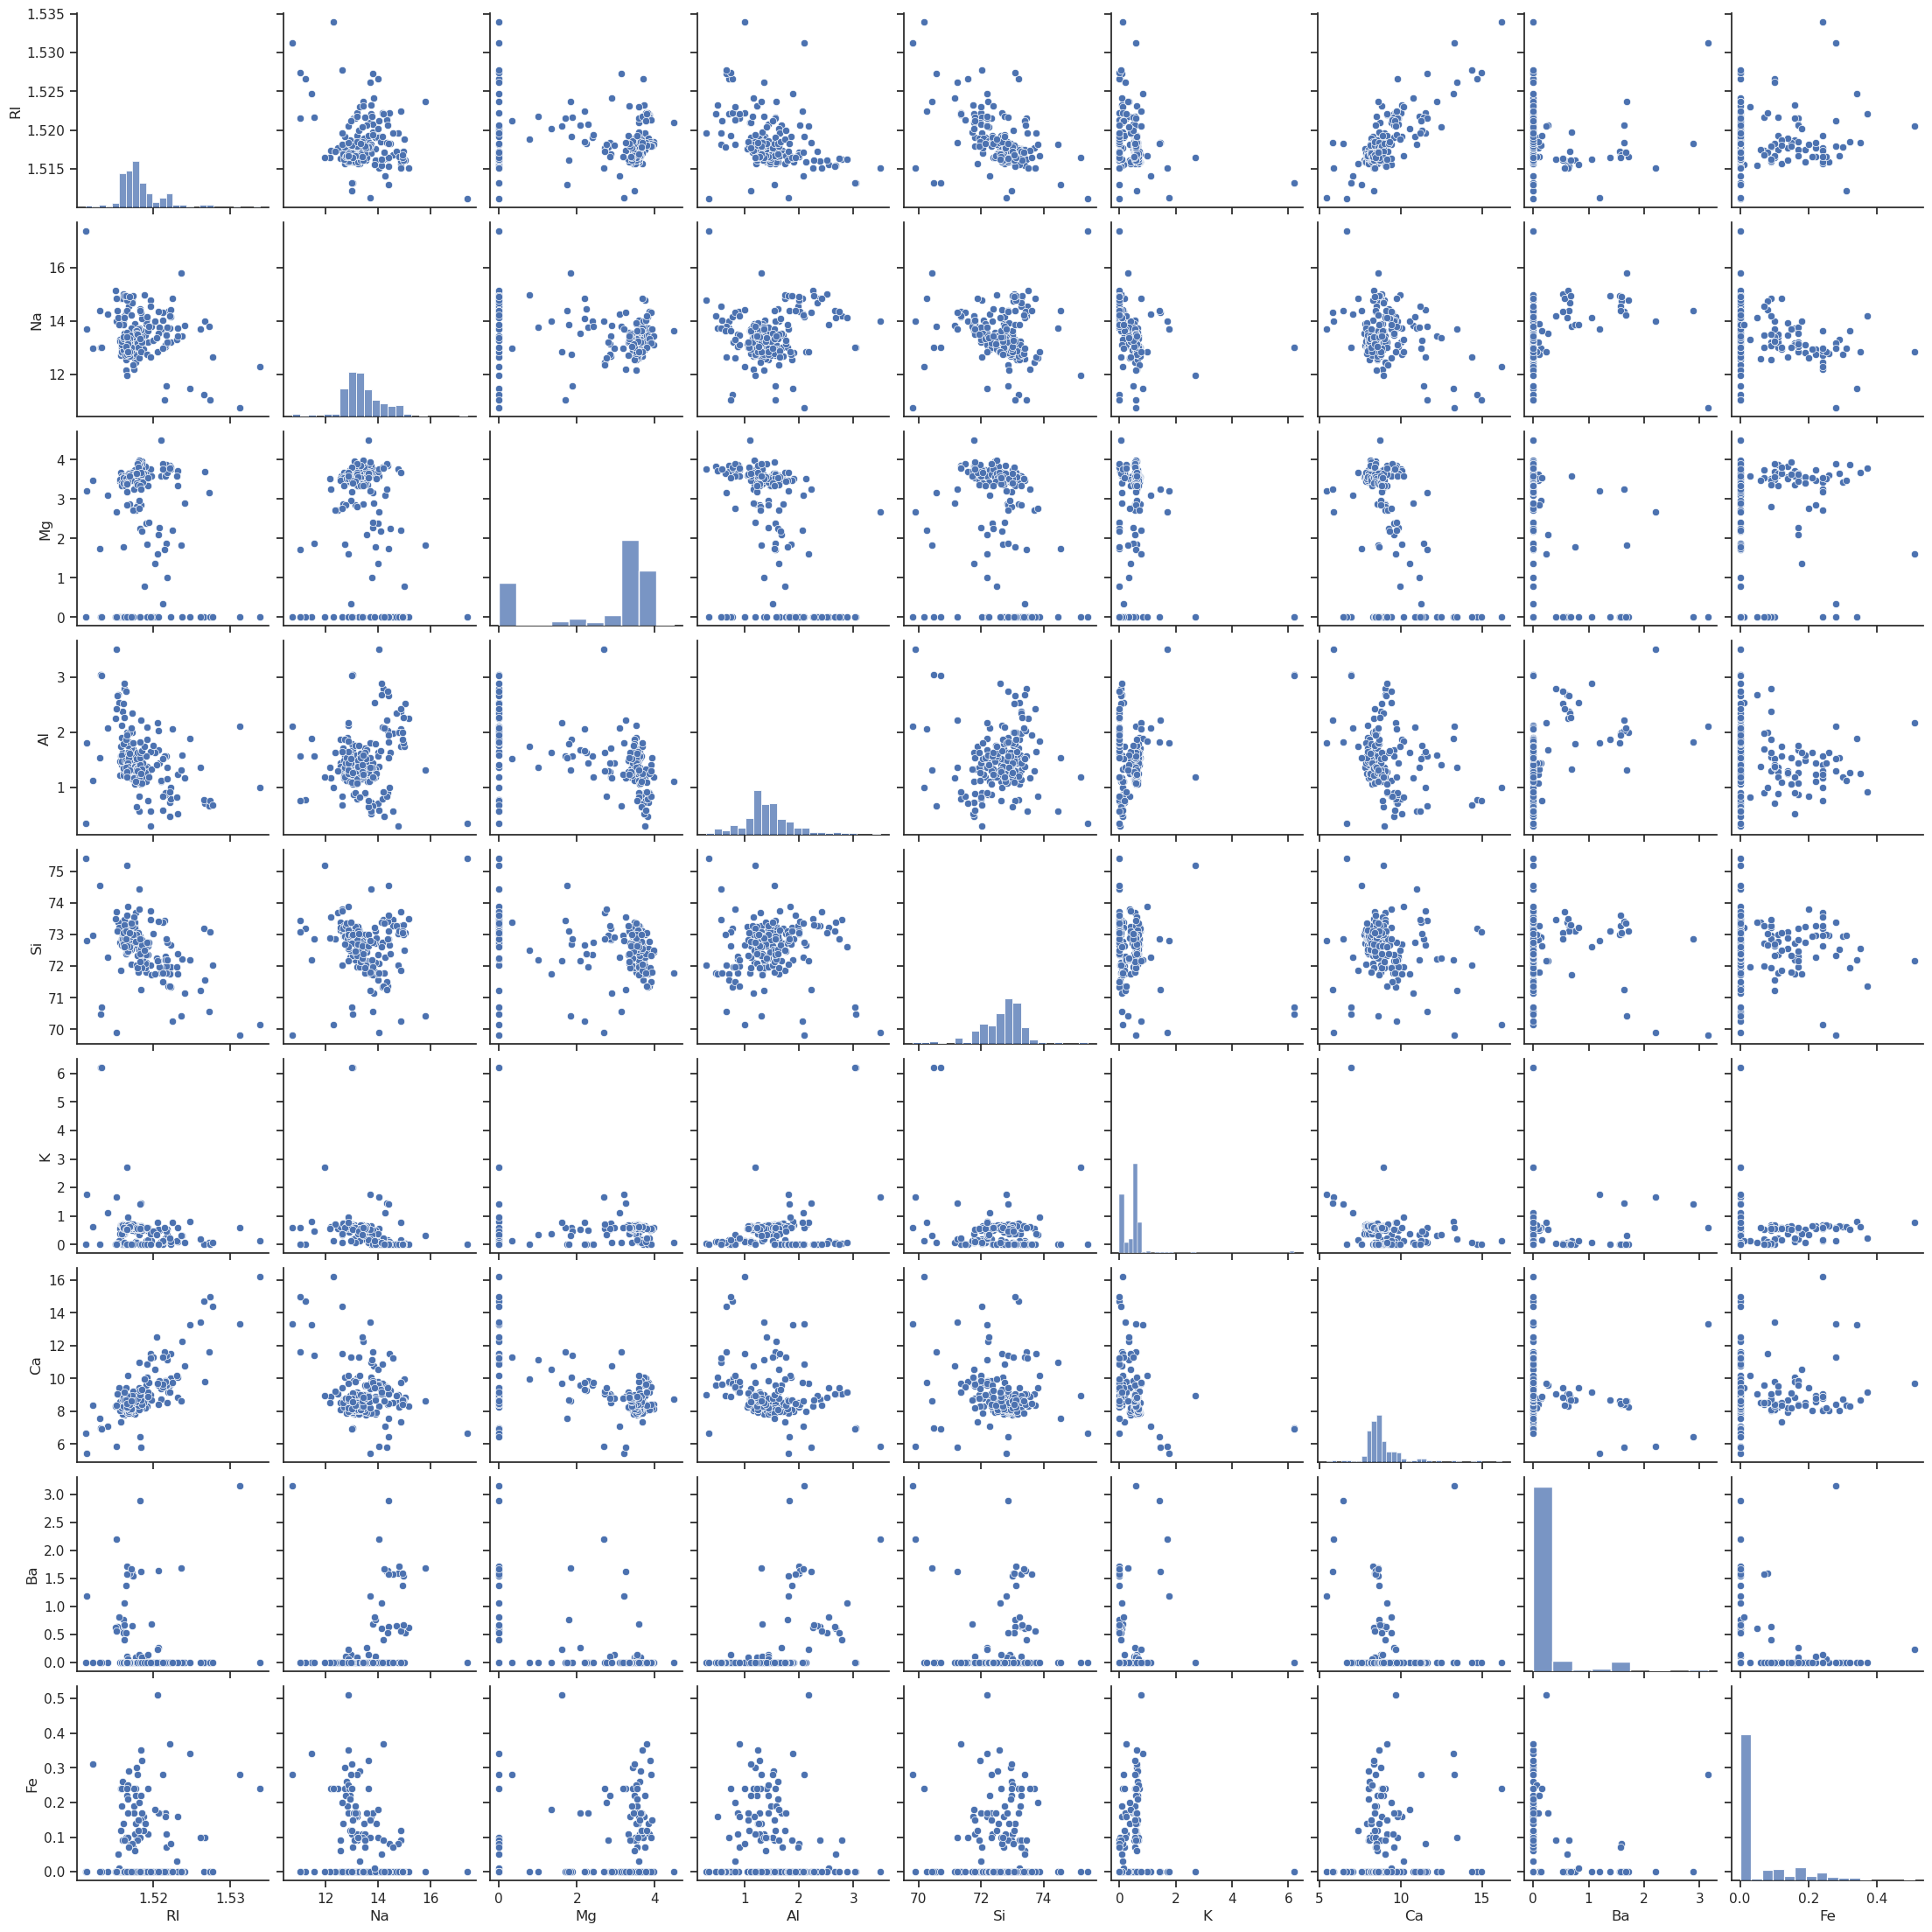

In [7]:
features = df.drop('Type', axis=1)

# Set the style
sns.set(style="ticks")

# Create the pair plot with color palette
plt.figure(figsize=(8, 8))
sns.pairplot(features, palette='coolwarm')

# Show the plot
plt.show()


<Figure size 1000x1000 with 0 Axes>

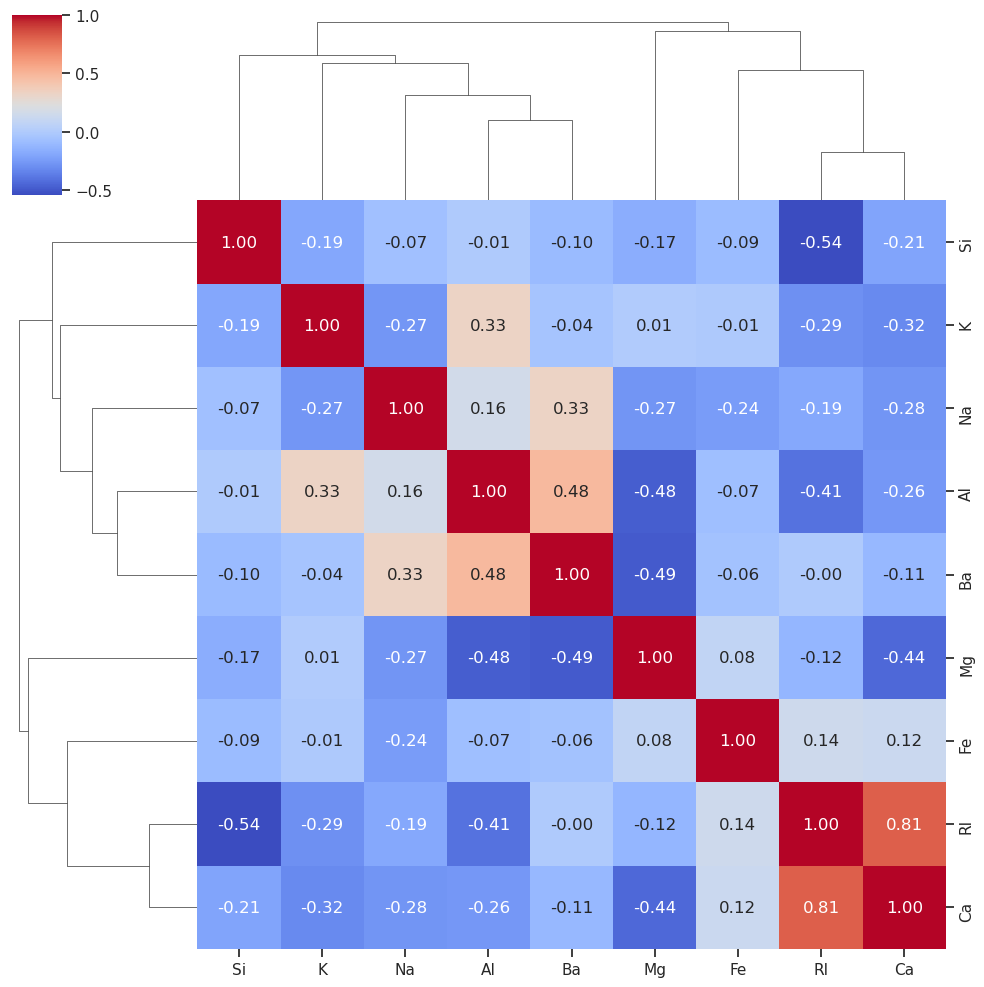

In [8]:
# clustermap for colleration matrix
plt.figure(figsize=(10, 10))
sns.clustermap(features.corr(), cmap='coolwarm', annot=True, fmt=".2f")

# Show the plot
plt.show()

### Outliers

In [9]:
def outliers(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_ind = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
         # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_ind.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_ind = Counter(outlier_ind)        
    multiple_outliers = list( k for k, v in outlier_ind.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outliers(features))))   

The dataset contains 14 observations with more than 2 outliers


In [10]:
df.shape

(214, 10)

In [11]:
outlier_ind = outliers(df[df.columns[:-1]])
df = df.drop(outlier_ind).reset_index(drop=True)
print(df.shape)

(200, 10)


### Model Evaluation

I will start by comparing KNN, LogisticRegression and DecisionTreeClassifier

In [12]:
x = df.drop('Type', axis = 1)
y = df['Type']
print(x.shape)
print(y.shape)

(200, 9)
(200,)


In [13]:
seed = 24
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 9)
(40, 9)
(160,)
(40,)


In [14]:
models = {'knn': KNeighborsClassifier(), 'logreg': LogisticRegression(random_state = seed), 'svm': SVC(random_state = seed), 'dt': DecisionTreeClassifier(random_state = seed)}

#### Scaling

In [15]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

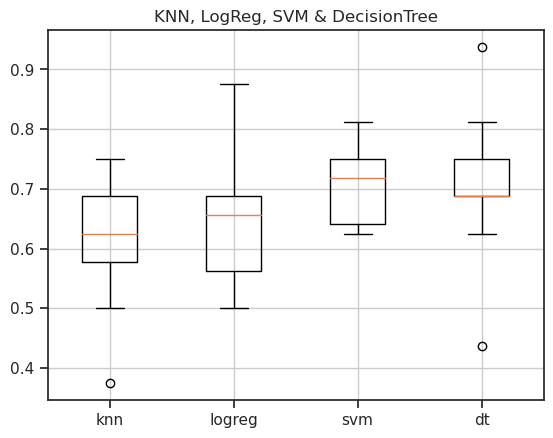

In [16]:
results = []

for model in models.values():
    cv_results = cross_val_score(model, x_train_s, y_train, cv=10)
    results.append(cv_results)    
plt.boxplot(results, labels = models.keys())
plt.title('KNN, LogReg, SVM & DecisionTree')
plt.grid(True)
plt.show()

Looks SVC has a better train set accuracy.

In [17]:
for name, model in models.items():
    model.fit(x_train_s, y_train)
    y_pred = model.predict(x_test_s)
    test_score = model.score(x_test_s, y_test)
    report = classification_report(y_test, y_pred)
    print('{} Test set accuracy: {:.3f}'.format(name, test_score))
    print('\n{} Classification Report:\n{}'.format(name, report))

knn Test set accuracy: 0.775

knn Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.82      0.69        11
           2       0.77      0.71      0.74        14
           3       0.00      0.00      0.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         8

    accuracy                           0.78        40
   macro avg       0.73      0.76      0.74        40
weighted avg       0.73      0.78      0.75        40

logreg Test set accuracy: 0.750

logreg Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.73      0.70        11
           2       0.67      0.71      0.69        14
           3       0.00      0.00      0.00         3
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7

The non-linera SVC is performing well on this particular task.

Decision Tree classifier had a high train accuracy and now we see a lower test set accuracy. This confirms how DecisionTreeClassifier with default parameters overfits the data.

### Ensemble

Now lets see the <mark>votingcalssifier</mark> for these four models

In [18]:
knn_classifier = KNeighborsClassifier()
logreg_classifier = LogisticRegression(random_state = seed)
svm = SVC(random_state = seed)
decision_tree_classifier = DecisionTreeClassifier(random_state = seed)

# Create a list of (name, estimator) tuples
classifiers = [
    ('KNN', knn_classifier),
    ('LogReg', logreg_classifier),
    ('SVM', svm),
    ('DecisionTree', decision_tree_classifier)]

In [19]:
vc = VotingClassifier(estimators = classifiers)
vc.fit(x_train_s, y_train)
y_pred = vc.predict(x_test_s)
print('Voting Classifier train set accuracy:', vc.score(x_train_s, y_train))
print('Voting Classifier Accuracy Score:', accuracy_score(y_test, y_pred))

Voting Classifier train set accuracy: 0.81875
Voting Classifier Accuracy Score: 0.8


The VotingClassifier seem to perform close to SVC

#### Bagging and Out of Bag Evaluation

In [20]:
dt = DecisionTreeClassifier(random_state = seed)

bc = BaggingClassifier(base_estimator = dt, n_estimators = 300, oob_score = True, n_jobs = -1)
bc.fit(x_train_s, y_train)
y_pred = bc.predict(x_test_s)
test_accuracy = accuracy_score(y_test, y_pred)
obb_accuracy = bc.oob_score_
print('Test set accuracy:', test_accuracy)
print('oob accuracy:', obb_accuracy)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Test set accuracy: 0.8
oob accuracy: 0.725


It's performs on train set is same as that of KNN

Decision Tree With default hyperparameters might be overfitting our data. We see a lower oob score.

### Random Forests

In [21]:
rf = RandomForestClassifier(random_state = seed, n_estimators = 300)
rf.fit(x_train_s, y_train)
y_pred = rf.predict(x_test_s)
train_accuracy = rf.score(x_train_s, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print('Train set accuracy:', train_accuracy)
print('Test set accuracy:', test_accuracy)

Train set accuracy: 1.0
Test set accuracy: 0.85


Random forest has performed better tha SVC

#### Feature Importance

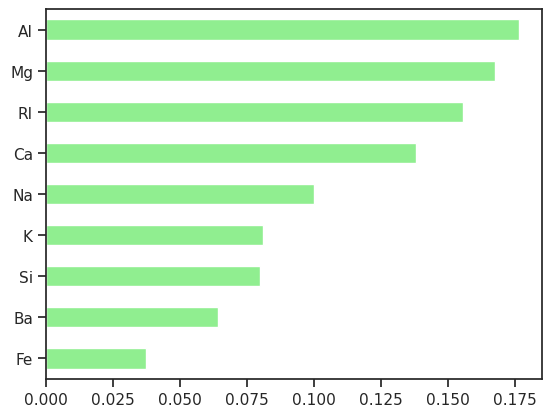

In [22]:
importances_rf = pd.Series(rf.feature_importances_, index = x.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind = 'barh', color = 'lightgreen')
plt.show()

### GradientBoosting

In [23]:
gb = GradientBoostingClassifier(random_state = seed, n_estimators = 300)
gb.fit(x_train_s, y_train)
y_pred = rf.predict(x_test_s)
train_accuracy = gb.score(x_train_s, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print('Train set accuracy:', train_accuracy)
print('Test set accuracy:', test_accuracy)

Train set accuracy: 1.0
Test set accuracy: 0.85


Its performing just like the Random Forest

### Stochastic Gradient Boosting (SGB) 

In [24]:
sgb = GradientBoostingClassifier(random_state=seed, n_estimators=300, subsample=0.8)
sgb.fit(x_train_s, y_train)
y_pred = sgb.predict(x_test_s)
train_accuracy = sgb.score(x_train_s, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print('Train set accuracy:', train_accuracy)
print('Test set accuracy:', test_accuracy)

Train set accuracy: 1.0
Test set accuracy: 0.9


It has performed better than all the others

### Hyperparameter Tuning 

We will tune the hyperparameters to obtain optimal SGB

In [25]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Create the SGB model
sgb = GradientBoostingClassifier(random_state=seed)

# Perform grid search with cross-validation
grid_search = GridSearchCV(sgb, param_grid, cv=10, n_jobs=-1, verbose = 1)
grid_search.fit(x_train_s, y_train)
best_model = grid_search.best_estimator_

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Best Model:", best_model)
print("Test Accuracy:", best_model.score(x_test_s, y_test))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.7875
Best Model: GradientBoostingClassifier(learning_rate=0.2, random_state=24, subsample=0.8)
Test Accuracy: 0.825


#### <mark> Any comments about this</mark>